## NYC Taxi Demand Dataset for Time-series Anomaly Detection
Number of NYC taxi passengers, where the five anomalies occur during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm. The raw data is from the NYC Taxi and Limousine Commission. The data file included here consists of aggregating the total number of taxi passengers into 30 minute buckets.

In [ ]:
!pip install fbprophet

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os

from datetime import datetime
import pandas as pd
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [ ]:
# The Numenta Anomaly Benchmark NYC Taxi Demand dataset

df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')

In [ ]:
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  10320 non-null  object
 1   value      10320 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.4+ KB


In [ ]:
# 데이터 타입 변경
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10320 non-null  datetime64[ns]
 1   value      10320 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 161.4 KB


In [ ]:
# Timestamp 컬럼을 인덱스로 지정하고 시간(Hour)단위로 리샘플
df = df.set_index('timestamp').resample('H').mean()

In [ ]:
df.head()

,value
timestamp,
2014-07-01 00:00:00,9485.5
2014-07-01 01:00:00,5433.0
2014-07-01 02:00:00,3346.5
2014-07-01 03:00:00,2216.5
2014-07-01 04:00:00,2189.5


In [ ]:
fig = px.line(df.reset_index(), x='timestamp', y='value', title='NYC Taxi Demand')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                      dict(count=1, label="1y", step="year", stepmode="backward"),
                      dict(count=2, label="3y", step="year", stepmode="backward"),
                      dict(count=3, label="5y", step="year", stepmode="backward"),
                      dict(step="all")
        ])
    )
)
fig.show()

In [ ]:
from fbprophet import Prophet

ARIMA 같은 시계열 모델은 시간에 종속적인 구조를 가지는 반면 Prophet은 시간에 종속적이지 않고 Curve Fitting 으로 문제를 해결함.

In [ ]:
# 컬럼 이름을 'ds, y' 으로 맞추어야함. 
taxi_df = df.reset_index()[['timestamp', 'value']].rename({'timestamp':'ds', 'value':'y'}, axis='columns')

In [ ]:
taxi_df.head()

,ds,y
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5


In [ ]:
taxi_df.shape

(5160, 2)

In [ ]:
taxi_df.tail()

,ds,y
5155,2015-01-31 19:00:00,28288.5
5156,2015-01-31 20:00:00,24138.0
5157,2015-01-31 21:00:00,24194.5
5158,2015-01-31 22:00:00,26515.0
5159,2015-01-31 23:00:00,26439.5


In [ ]:
taxi_df.ds.min(), taxi_df.ds.max()

(Timestamp('2014-07-01 00:00:00'), Timestamp('2015-01-31 23:00:00'))

In [ ]:
train = taxi_df[(taxi_df['ds'] <='2015-01-30')]
test = taxi_df[(taxi_df['ds'] >'2015-01-30')]

In [ ]:
train.shape, test.shape

((5113, 2), (47, 2))

In [ ]:
model = Prophet(seasonality_mode='additive', interval_width=0.8, changepoint_range=0.95)

- Prophet 에서 기본적으로 트렌드가 변경되는 지점을 자동으로 감지해 트렌드를 예측함.
- Prophet 객체를 생성할 때, changepoint_range, changepoint_prior_scale, chagepoints 값 조정
- interval_width 값으로 예측 값의 불확실성 범위 조정(예측 정확도, 기본값 80%)
- Seasonlity는 데이터에 따라 'additive(기본값)', 'multiplicative' 로 설정

In [ ]:
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
# 예측(미래) Dataframe 생성
future = model.make_future_dataframe(periods=47, freq='H')

In [ ]:
future.shape

(5160, 1)

In [ ]:
forecast = model.predict(future)

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2014-07-01 00:00:00,13093.943670,8305.616336,17501.361780
1,2014-07-01 01:00:00,10062.342551,5286.169215,14692.709754
2,2014-07-01 02:00:00,6494.560854,1848.370427,11290.266425
3,2014-07-01 03:00:00,3286.631811,-1767.615931,8152.189363
4,2014-07-01 04:00:00,1874.548059,-2841.983556,6568.532639
...,...,...,...,...
5155,2015-01-31 19:00:00,22948.620082,18466.382584,27945.330404
5156,2015-01-31 20:00:00,23509.776508,18752.127020,28585.124594
5157,2015-01-31 21:00:00,22385.233433,17536.631636,27157.938267
5158,2015-01-31 22:00:00,20185.774492,15282.380848,24735.158347


In [ ]:
results = pd.concat([taxi_df.set_index('ds')['y'], forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]], axis=1)

In [ ]:
results.head()

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2014-07-01 00:00:00,9485.5,13093.943670,8305.616336,17501.361780
2014-07-01 01:00:00,5433.0,10062.342551,5286.169215,14692.709754
2014-07-01 02:00:00,3346.5,6494.560854,1848.370427,11290.266425
2014-07-01 03:00:00,2216.5,3286.631811,-1767.615931,8152.189363
2014-07-01 04:00:00,2189.5,1874.548059,-2841.983556,6568.532639


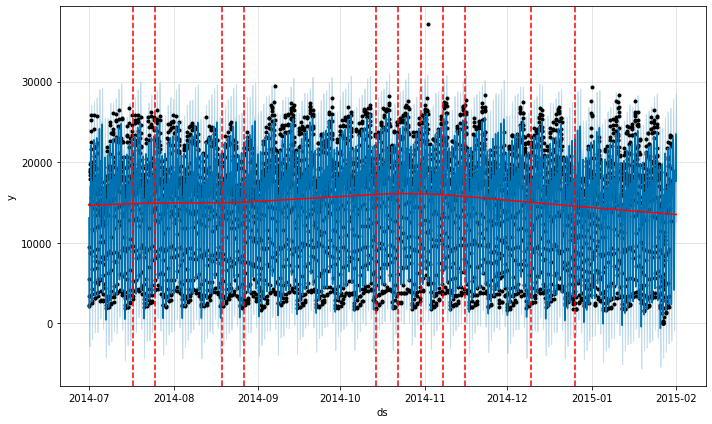

In [ ]:
from fbprophet.plot import add_changepoints_to_plot

fig1 = model.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), model, forecast)

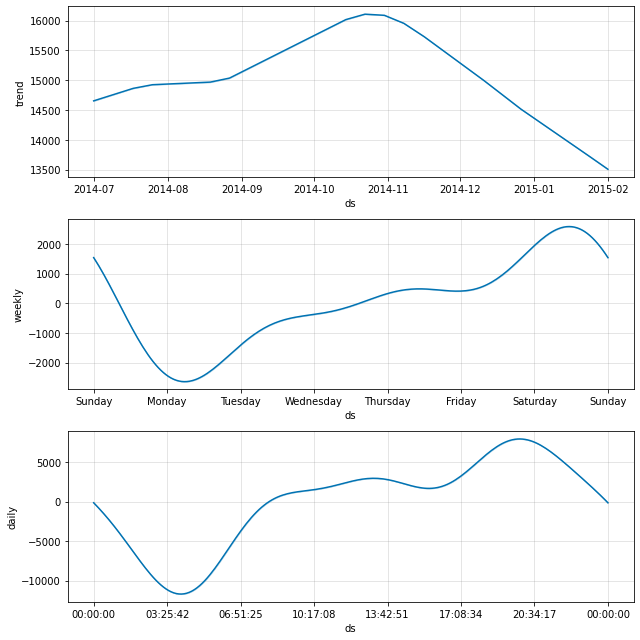

In [ ]:
comp = model.plot_components(forecast)

In [ ]:
results.head()

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2014-07-01 00:00:00,9485.5,13093.943670,8305.616336,17501.361780
2014-07-01 01:00:00,5433.0,10062.342551,5286.169215,14692.709754
2014-07-01 02:00:00,3346.5,6494.560854,1848.370427,11290.266425
2014-07-01 03:00:00,2216.5,3286.631811,-1767.615931,8152.189363
2014-07-01 04:00:00,2189.5,1874.548059,-2841.983556,6568.532639


In [ ]:
results['error'] = results['y'] - results['yhat']
results['uncertainty'] = results['yhat_upper'] - results['yhat_lower']

In [ ]:
results.head()

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2014-07-01 00:00:00,9485.5,13093.943670,8305.616336,17501.361780,-3608.443670,9195.745444
2014-07-01 01:00:00,5433.0,10062.342551,5286.169215,14692.709754,-4629.342551,9406.540539
2014-07-01 02:00:00,3346.5,6494.560854,1848.370427,11290.266425,-3148.060854,9441.895997
2014-07-01 03:00:00,2216.5,3286.631811,-1767.615931,8152.189363,-1070.131811,9919.805294
2014-07-01 04:00:00,2189.5,1874.548059,-2841.983556,6568.532639,314.951941,9410.516195


In [ ]:
results[results['error'].abs() > 1.5 * results['uncertainty']]

,y,yhat,yhat_lower,yhat_upper,error,uncertainty
ds,,,,,,
2014-11-02 01:00:00,37204.5,14153.757440,9490.447258,19207.412739,23050.742560,9716.965481
2015-01-01 01:00:00,29292.0,11451.418450,6812.980627,16515.416026,17840.581550,9702.435399
2015-01-01 02:00:00,25753.5,7824.187644,3069.712599,12738.382900,17929.312356,9668.670301
2015-01-01 03:00:00,22067.0,4557.576625,-418.651674,9423.625491,17509.423375,9842.277165
2015-01-26 20:00:00,3630.5,19787.218800,14818.784236,24294.143175,-16156.718800,9475.358939
2015-01-26 21:00:00,2907.0,18875.806079,14069.332696,23414.973210,-15968.806079,9345.640514
2015-01-26 22:00:00,1324.5,16900.864238,12403.072186,21610.076840,-15576.364238,9207.004654
2015-01-26 23:00:00,243.0,14590.691572,9762.774228,19155.604561,-14347.691572,9392.830334


- '2014-11-02' : NYC 마라톤 대회 개최 - 택시수요량 급증
- '2015-01-01' : 타임스퀘어에서 새해 행사 진행 - 택시수요량 급증
- '2015-01-26' : 미 북동부 사상최악 폭설 - 택시수요량 급감

In [ ]:
results['anomaly'] = results.apply(lambda x: 'Yes' if (np.abs(x['error']) > 1.5 * x['uncertainty']) else 'No', axis=1)

In [ ]:
results['anomaly'].value_counts()

No     5152
Yes       8
Name: anomaly, dtype: int64

In [ ]:
fig = px.scatter(results.reset_index(), x='ds', y='y', color='anomaly', title='NYC Taxi Demand')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                      dict(count=1, label="1y", step="year", stepmode="backward"),
                      dict(count=2, label="3y", step="year", stepmode="backward"),
                      dict(count=3, label="5y", step="year", stepmode="backward"),
                      dict(step="all"),
        ])
    )
)

fig.show()

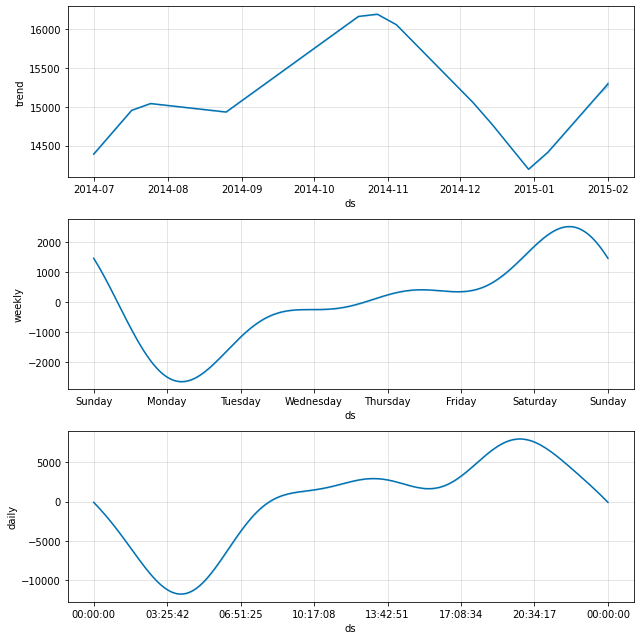

In [ ]:
comp = model.plot_components(forecast)